# Relation Extraction

**Задача**: 
1. (**DONE**) извлечь по определенным шаблонам и ограничениям биграммы из статей по физике;
2. (**DONE**) проанализировать частотности биграмм;
3. (**DONE**) выделить контексты (предложения) для каждого кандидата;
4. классифицировать каждый контекст по типу отношения с соответствующим термином-биграммой;
5. структурировать выдачу по классам отношений.

In [2]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm

from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.corpus import stopwords
import pymorphy2 as pm2

### 1. Data Preprocessing

#### 1.1 Loading corpus

Загрузим датасет - корпус научных статей по физике:

In [3]:
data_directory = '../data/elibrary_physics_15k'
article_id = re.compile(r'_([0-9]+).htm$')

file_contents = []
for filename in tqdm(os.scandir(data_directory), desc='Loading data'):
    if filename.is_file():
        file_name = filename.name
        file_id = int(article_id.search(file_name).groups(1)[0])
        
        with open(filename, "r", encoding='utf-8') as f:
            text = f.read()
            file_contents.append((file_id, text))

print(f'Размер корпуса: {len(file_contents)} статей')

Loading data: 0it [00:00, ?it/s]

Размер корпуса: 15000 статей


#### 1.2 Filtering out non-russian articles

Удалим из корпуса статьи, написанные не на русском языке.

In [4]:
MIN_CYRILLIC_THRESHOLD = 0.2

cyrillic_sym = re.compile(r'[а-яёА-ЯЁ]')

Алгоритм отсеивания статей по языку:
1. подсчитывается кол-во кириллических символов в статье;
2. если соотношение кириллицы >= MIN_CYRILLIC_THRESHOLD -> статья русскоязычная.

In [5]:
rus_articles = []

for article in tqdm(file_contents, desc='Filtering out non-russian articles'):
    rus_count = 0
    for _ in cyrillic_sym.finditer(article[1]):
        rus_count += 1

    if rus_count >= len(article[1]) * MIN_CYRILLIC_THRESHOLD:
        rus_articles.append(article)

print(f'Удалено нерусскоязычных статей: {len(file_contents) - len(rus_articles)}')

Filtering out non-russian articles:   0%|          | 0/15000 [00:00<?, ?it/s]

Удалено нерусскоязычных статей: 4062


In [6]:
articles_count = len(rus_articles)
print(f'Кол-во русскоязычных статей: {articles_count}')

Кол-во русскоязычных статей: 10938


#### 1.3 Filtering matching bigrams

Найдем в текстах статей биграммы следующих типов:
1. прилагательное + существительное *(им. падеж)*;
2. существительное *(им. падеж)* + существительное *(род. падеж)*.

In [7]:
lemmatizer = pm2.MorphAnalyzer(lang='ru')

In [8]:
def match_bigram(word1_parse, word2_parse):
    """
    Tries to match bigram of w1 and w2 with any of the patterns.
    If succeed, returns a tuple ((w1_norm, w2_norm), pattern).
    """
    word1_pos = word1_parse.tag.POS
    word2_pos = word2_parse.tag.POS

    # failed pattern matching
    if word2_pos != 'NOUN' or word1_pos not in {'NOUN', 'ADJF'}:
        return None

    word1_inflection = (word1_parse.tag.gender, word1_parse.tag.number, word1_parse.tag.case)
    word2_inflection = (word2_parse.tag.gender, word2_parse.tag.number, word2_parse.tag.case)

    # 'adj + noun' pattern
    if (
        word1_pos == 'ADJF' and word2_pos == 'NOUN' 
        and word1_inflection[1] == word2_inflection[1]
        and word1_inflection[2] == word2_inflection[2]
        and (
            word1_inflection[0] == word2_inflection[0]
            or word1_inflection[0] is None and word1_inflection[1] == 'plur'
        )
    ):
        return (word1_parse.normal_form, word2_parse.normal_form), 'прил. + сущ.'

    # 'noun + noun' pattern
    if word1_pos == 'NOUN' and word2_pos == 'NOUN' and word2_inflection[2] == 'gent':
        return (word1_parse.normal_form, word2_parse.normal_form), 'сущ. + сущ.'

    return None

Зададим список стоп-слов:

In [9]:
stop_words = stopwords.words('russian')

stop_words.extend(
    [
        # adjective-like pronouns
        'мой', 'твой', 'ваш', 'наш', 'свой', 'его', 'ее', 'их',
        'тот', 'этот', 'такой', 'таков', 'сей', 'который',
        'весь', 'всякий', 'сам', 'самый', 'каждый', 'любой', 'иной', 'другой',
        'какой', 'каков', 'чей', 'никакой', 'ничей',
        'какой-то', 'какой-либо', 'какой-нибудь', 'некоторый', 'некий',
        # participles
        'соответствующий', 'следующий', 'данный',
        # numerals
        'один',
        # insignificant words
        'друг',
    ]
)

stop_words = set(stop_words)

Зададим список стоп-биграмм:

In [10]:
stop_bigrams = []

stop_bigrams.extend(
    [
        ('крайний', 'мера'), ('сегодняшний', 'день'), ('настоящий', 'время'), ('настоящий', 'работа'),
        ('настоящий', 'статья'), ('точка', 'зрение'), ('первый', 'очередь'), ('последний', 'год'),
    ]
)

stop_bigrams = set(stop_bigrams)

Подходящие слова должны содержать только буквы и дефисы (последние не в начале/конце слова):

In [11]:
def match_unigram(word):
    """Checks if a word is long enough and contains only letters and dashes."""
    if word.startswith('-') or word.endswith('-'):
        return False

    word_dashless = word.replace('-', '')
    return len(word_dashless) >= 3 and word_dashless.isalpha()

Bottleneck лемматизации - обращения к pymorphy2. Сократим кол-во обращений к анализатору, кешируя морфологические разборы токенов:

In [12]:
def get_or_cache_token_parse(lemmatizer, token, cache):
    """Extracts token parse from cache, or adds it to the latter if not found."""
    if token in cache:
        token_parse = cache[token]
    else:
        token_parse = lemmatizer.parse(token)[0]
        cache[token] = token_parse

    return token_parse

Реализуем единый интерфейс сохранения tf для n-грамм:

In [13]:
def update_tf_stats(n_gram_info, n_gram_collection, n):
    """Updates n-gram TF statistics with given n-gram."""
    # unigram
    if n == 1:
        if n_gram_info not in n_gram_collection:
            n_gram_collection[n_gram_info] = {
                'TF': 1,
                'DF': 0,
            }
        else:
            n_gram_collection[n_gram_info]['TF'] += 1
    # bigram
    elif n == 2:
        n_gram, n_gram_pattern = n_gram_info
        if n_gram not in n_gram_collection:
            n_gram_collection[n_gram] = {
                'Articles': [],
                'Pattern': n_gram_pattern,
                'TF': 1,
                'DF': 0,
            }
        else:
            n_gram_collection[n_gram]['TF'] += 1

*Следующий шаг **не нужно выполнять**, если биграммы уже записаны в датафрейм.*

Сохраним о каждой подходящей биграмме следующую информацию:
- список статей, где была встречена биграмма;
- тип биграммы (прил. + сущ. | сущ. + сущ.);
- частота встречаемости (TF);
- подокументная частота (DF).

In [14]:
pm2_cache, bigram_stats, unigram_stats = {}, {}, {}
corpus_size = 0

for article_id, article_text in tqdm(rus_articles, desc='Lemmatizing articles'):
    # tokenization
    tokens = word_tokenize(article_text.lower(), language='russian')

    # short and/or non-letter words removal
    standardized_tokens = []
    for token in tokens:
        if match_unigram(token):
            standardized_tokens.append(token)

    prev_unigram = None
    unique_bigrams, unique_unigrams = set(), set()
    for i in range(len(standardized_tokens) - 1):
        token1, token2 = standardized_tokens[i], standardized_tokens[i + 1]

        # bigram parse data extraction
        token1_parse = get_or_cache_token_parse(lemmatizer, token1, pm2_cache)
        token2_parse = get_or_cache_token_parse(lemmatizer, token2, pm2_cache)

        # stop-words removal
        if token1_parse.normal_form in stop_words or token2_parse.normal_form in stop_words:
            continue

        # bigram extraction
        bigram_info = match_bigram(token1_parse, token2_parse)
        if bigram_info is not None:
            bigram, bigram_pattern = bigram_info

            # stop-bigrams removal
            if bigram in stop_bigrams:
                continue

            unique_bigrams.add(bigram)
            unique_unigrams.update(bigram)

            # bigram TF statistics update
            update_tf_stats(bigram_info, bigram_stats, 2)

            # unigram TF statistics update
            if bigram[0] != prev_unigram:
                corpus_size += 1
                update_tf_stats(bigram[0], unigram_stats, 1)

            prev_unigram = bigram[1]
            corpus_size += 1
            update_tf_stats(bigram[1], unigram_stats, 1)

    # DF statistics update
    for bigram in unique_bigrams:
        bigram_stats[bigram]['DF'] += 1
        bigram_stats[bigram]['Articles'].append(article_id)
    for unigram in unique_unigrams:
        unigram_stats[unigram]['DF'] += 1

Lemmatizing articles:   0%|          | 0/10938 [00:00<?, ?it/s]

In [15]:
print(f'Количество подходящих униграмм: {corpus_size}')

Количество подходящих униграмм: 6546389


In [16]:
print(f'Количество подходящих биграмм: {len(bigram_stats)}')

Количество подходящих биграмм: 661886


#### 1.4 Saving extracted data

Оставим биграммы, удовлетворяющие следующим условиям:
- 10 <= df <= 150;
- tf >= df * 5.

In [17]:
relevant_bigrams = {}

for bigram, stats in bigram_stats.items():
    if (
        stats['DF'] >= 10 and stats['DF'] <= 150
        and stats['TF'] >= stats['DF'] * 5
    ):
        relevant_bigrams[bigram] = stats

In [18]:
bigram_df = pd.DataFrame(relevant_bigrams).T.reset_index()
bigram_df.rename(
    columns={
        'level_0': 'unigram_1',
        'level_1': 'unigram_2',
        'Articles': 'articles_id_list',
        'Pattern': 'pos_pattern',
        'TF': 'tf',
        'DF': 'df',
    },
    inplace=True,
)

bigram_df = bigram_df[['unigram_1', 'unigram_2', 'pos_pattern', 'tf', 'df', 'articles_id_list']]

bigram_df

,unigram_1,unigram_2,pos_pattern,tf,df,articles_id_list
0,электронный,концентрация,прил. + сущ.,540,107,"[10007912, 10023336, 10120935, 10120938, 11032..."
1,молекула,краситель,сущ. + сущ.,307,50,"[10007914, 10082536, 10425740, 11032681, 11135..."
2,фактор,эффективность,сущ. + сущ.,85,17,"[10007916, 11032039, 11148725, 11603561, 11633..."
3,спиновый,релаксация,прил. + сущ.,124,24,"[10007917, 11649305, 11705107, 11709827, 11722..."
4,квантовый,точка,прил. + сущ.,657,127,"[10007929, 10026573, 10303945, 10334562, 10334..."
...,...,...,...,...,...,...
230,химический,модель,прил. + сущ.,59,11,"[11683975, 11734542, 9491488, 9498659, 9516667..."
231,российский,журнал,прил. + сущ.,67,10,"[11732555, 11732559, 11732567, 11732569, 11735..."
232,дефект,замещение,сущ. + сущ.,70,11,"[11770472, 11788978, 12418224, 9464446, 953463..."
233,цепочка,тода,сущ. + сущ.,104,10,"[11787164, 9451134, 9469530, 9521572, 9521573,..."


Оставим униграммы, удовлетворяющие следующему условию:
- df >= 10.

In [19]:
unigram_df = pd.DataFrame(unigram_stats).T.reset_index()
unigram_df.rename(
    columns={
        'index': 'normal_form',
        'TF': 'tf',
        'DF': 'df',
    },
    inplace=True,
)
unigram_df = unigram_df[unigram_df['df'] >= 10].reset_index(drop=True)

unigram_df

,normal_form,tf,df
0,многолетний,58,49
1,исследование,22829,7669
2,учёный,487,269
3,эксплуатационный,334,249
4,среда,14040,3399
...,...,...,...
10128,кгт,14,12
10129,шварц,46,16
10130,тонкоструктурный,30,11
10131,импуля,11,11


Сохраним информацию об n-граммах:

In [20]:
bigram_df.to_csv('../data/data_frames/bigram_stats.csv')
unigram_df.to_csv('../data/data_frames/unigram_stats.csv')

### 2. Data Analysis

*Всегда теперь будем **только подгружать** сгенерированные датафреймы.*

In [21]:
bigram_df = pd.read_csv('../data/data_frames/bigram_stats.csv', index_col=0)
unigram_df = pd.read_csv('../data/data_frames/unigram_stats.csv', index_col=0)

corpus_size = 6546389

Посчитаем метрики tf-idf и mi3 для биграмм.

#### 2.1 TF-IDF

In [22]:
idf = bigram_df['df'].apply(lambda x: np.log10(articles_count / x))
tf_idf = bigram_df['tf'] * idf

bigram_tf_idf_df = bigram_df.copy()
bigram_tf_idf_df['tf_idf'] = tf_idf
bigram_tf_idf_df.sort_values(by=['tf_idf'], ignore_index=True, inplace=True, ascending=False)
bigram_tf_idf_df = bigram_tf_idf_df.round(decimals=2)

bigram_tf_idf_df

,unigram_1,unigram_2,pos_pattern,tf,df,articles_id_list,tf_idf
0,пылевой,частица,прил. + сущ.,661,42,"[10120932, 10120935, 11032152, 11480035, 11517...",1596.77
1,волна,накачка,сущ. + сущ.,764,112,"[10008538, 10008542, 10026568, 10120932, 10293...",1520.15
2,нелинейный,динамика,прил. + сущ.,727,142,"[10008371, 10026574, 10333081, 10425572, 11036...",1371.59
3,коэрцитивный,сила,прил. + сущ.,691,123,"[10007971, 10082546, 10336878, 10336887, 10594...",1346.78
4,квантовый,точка,прил. + сущ.,657,127,"[10007929, 10026573, 10303945, 10334562, 10334...",1271.38
...,...,...,...,...,...,...,...
230,содержание,озон,сущ. + сущ.,53,10,"[11031720, 11567558, 11748383, 12364874, 94826...",161.06
231,прямой,участок,прил. + сущ.,53,10,"[11529223, 11731576, 11806919, 9479144, 955196...",161.06
232,периодический,орбита,прил. + сущ.,50,10,"[10008371, 10208668, 11913953, 11913970, 11929...",151.95
233,остриё,кантилевер,сущ. + сущ.,50,10,"[11517667, 11533284, 11533460, 11601220, 11806...",151.95


#### 2.2 MI3

In [23]:
mi3_scores = []
for _, row in bigram_tf_idf_df.iterrows():
    unigram_1 = row['unigram_1']
    unigram_2 = row['unigram_2']
    bigram_tf = row['tf']

    unigram_1_tf = unigram_df[unigram_df['normal_form'] == unigram_1]['tf'].values[0]
    unigram_2_tf = unigram_df[unigram_df['normal_form'] == unigram_2]['tf'].values[0]

    mi3_scores.append(np.log2((corpus_size * bigram_tf ** 3) / (unigram_1_tf * unigram_2_tf)))

mi3_scores = np.array(mi3_scores)

bigram_mi3_df = bigram_tf_idf_df.copy()
bigram_mi3_df['mi3'] = mi3_scores

bigram_mi3_df = bigram_mi3_df[bigram_mi3_df['mi3'] >= 5]
bigram_mi3_df = bigram_mi3_df[bigram_mi3_df['mi3'] <= 25]

bigram_mi3_df.sort_values(by=['mi3'], ignore_index=True, inplace=True, ascending=False)
bigram_mi3_df = bigram_mi3_df.round(decimals=2)

bigram_mi3_df = bigram_mi3_df[['unigram_1', 'unigram_2', 'pos_pattern', 'tf', 'df', 'tf_idf', 'mi3', 'articles_id_list']]

bigram_mi3_df

,unigram_1,unigram_2,pos_pattern,tf,df,tf_idf,mi3,articles_id_list
0,цепочка,тода,сущ. + сущ.,104,10,316.05,24.83,"[11787164, 9451134, 9469530, 9521572, 9521573,..."
1,синглётный,кислород,прил. + сущ.,260,31,662.37,24.77,"[10120938, 11135154, 11143578, 11480223, 11602..."
2,кавитационный,пузырёк,прил. + сущ.,128,21,347.74,24.75,"[11526484, 11649253, 11665354, 11665464, 11685..."
3,акустический,эмиссия,прил. + сущ.,345,46,819.78,24.65,"[10007974, 10024625, 10082579, 10342058, 10344..."
4,вестник,мая,сущ. + сущ.,59,11,176.86,24.46,"[11642672, 11642676, 11642730, 11642743, 11729..."
...,...,...,...,...,...,...,...,...
206,форма,равновесие,сущ. + сущ.,56,10,170.18,14.51,"[10293695, 11137175, 11522763, 11665711, 11704..."
207,радиус,кристалл,сущ. + сущ.,72,14,208.28,14.08,"[10082492, 11520761, 11532544, 11571108, 11679..."
208,область,трещина,сущ. + сущ.,61,11,182.85,13.94,"[10293733, 10293734, 11526477, 11526483, 11529..."
209,химический,модель,прил. + сущ.,59,11,176.86,13.58,"[11683975, 11734542, 9491488, 9498659, 9516667..."


Сохраним частотную статистику по биграммам:

In [24]:
bigram_mi3_df.to_csv('../data/data_frames/bigram_tfidf_mi3_scores.csv')

#### 2.3 Visual representation

Увеличим кол-во отображаемых строк в датафреймах:

In [25]:
pd.set_option('display.max_rows', 250)

Отсортируем биграммы по убыванию tf-idf и mi3.

##### 2.3.1 Top TF-IDF

In [26]:
top_tf_idf = bigram_mi3_df.sort_values(by=['tf_idf'], ignore_index=True, ascending=False)
top_tf_idf

,unigram_1,unigram_2,pos_pattern,tf,df,tf_idf,mi3,articles_id_list
0,волна,накачка,сущ. + сущ.,764,112,1520.15,24.20,"[10008538, 10008542, 10026568, 10120932, 10293..."
1,квантовый,точка,прил. + сущ.,657,127,1271.38,23.85,"[10007929, 10026573, 10303945, 10334562, 10334..."
2,число,фотон,сущ. + сущ.,627,125,1217.65,23.73,"[10008532, 10008540, 10303950, 10425428, 10425..."
3,токовый,слой,прил. + сущ.,437,31,1113.29,23.93,"[10286504, 11602115, 11606286, 11633765, 11685..."
4,электронный,концентрация,прил. + сущ.,540,107,1085.16,21.97,"[10007912, 10023336, 10120935, 10120938, 11032..."
5,плазменный,волна,прил. + сущ.,384,62,862.67,21.06,"[10082548, 10293597, 11032036, 11394073, 11394..."
6,канал,связь,сущ. + сущ.,382,66,847.81,21.22,"[10008526, 10026602, 10607216, 11032642, 11158..."
7,скорость,ветер,сущ. + сущ.,382,72,833.37,22.94,"[10133408, 10365657, 11032603, 11033109, 11394..."
8,ударный,слой,прил. + сущ.,312,25,823.99,20.98,"[10208691, 10208694, 11032152, 11131066, 11131..."
9,акустический,эмиссия,прил. + сущ.,345,46,819.78,24.65,"[10007974, 10024625, 10082579, 10342058, 10344..."


Отразим на графике топ-100 tf-idf рейтинга:

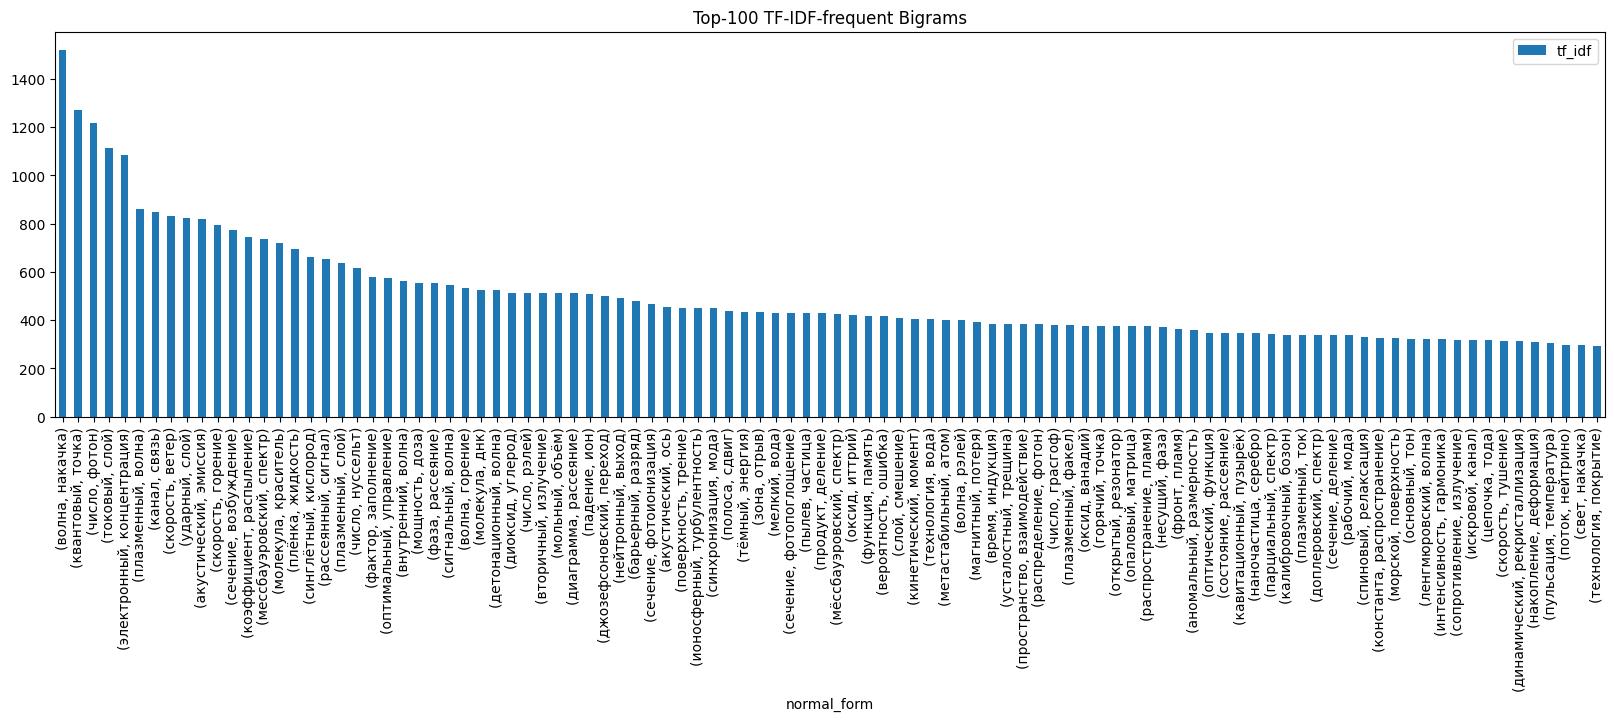

In [27]:
visual_tf_idf = bigram_mi3_df.copy()
visual_tf_idf = visual_tf_idf.sort_values(by=['tf_idf'], ignore_index=True, ascending=False)
visual_tf_idf['normal_form'] = list(zip(visual_tf_idf['unigram_1'], visual_tf_idf['unigram_2']))

tf_idf_plot = visual_tf_idf.head(100).plot(
    x='normal_form', y='tf_idf', kind='bar', title='Top-100 TF-IDF-frequent Bigrams', figsize=(20, 5)
)

##### 2.3.2 Top MI3

In [28]:
bigram_mi3_df

,unigram_1,unigram_2,pos_pattern,tf,df,tf_idf,mi3,articles_id_list
0,цепочка,тода,сущ. + сущ.,104,10,316.05,24.83,"[11787164, 9451134, 9469530, 9521572, 9521573,..."
1,синглётный,кислород,прил. + сущ.,260,31,662.37,24.77,"[10120938, 11135154, 11143578, 11480223, 11602..."
2,кавитационный,пузырёк,прил. + сущ.,128,21,347.74,24.75,"[11526484, 11649253, 11665354, 11665464, 11685..."
3,акустический,эмиссия,прил. + сущ.,345,46,819.78,24.65,"[10007974, 10024625, 10082579, 10342058, 10344..."
4,вестник,мая,сущ. + сущ.,59,11,176.86,24.46,"[11642672, 11642676, 11642730, 11642743, 11729..."
5,ионосферный,турбулентность,прил. + сущ.,157,15,449.47,24.32,"[11480855, 11600446, 11600448, 11652105, 11664..."
6,волна,накачка,сущ. + сущ.,764,112,1520.15,24.20,"[10008538, 10008542, 10026568, 10120932, 10293..."
7,известие,академия,сущ. + сущ.,89,16,252.30,24.14,"[10026311, 10341871, 11709639, 11709651, 11732..."
8,число,нуссельт,сущ. + сущ.,263,49,617.72,24.07,"[10082582, 10082584, 10082585, 10120906, 10208..."
9,здоровый,человек,прил. + сущ.,68,13,198.90,23.95,"[11143586, 11577085, 11692005, 11697524, 11734..."


Отразим на графике топ-100 mi3 рейтинга:

In [29]:
visual_mi3 = bigram_mi3_df.copy()
visual_mi3['normal_form'] = list(zip(visual_mi3['unigram_1'], visual_mi3['unigram_2']))

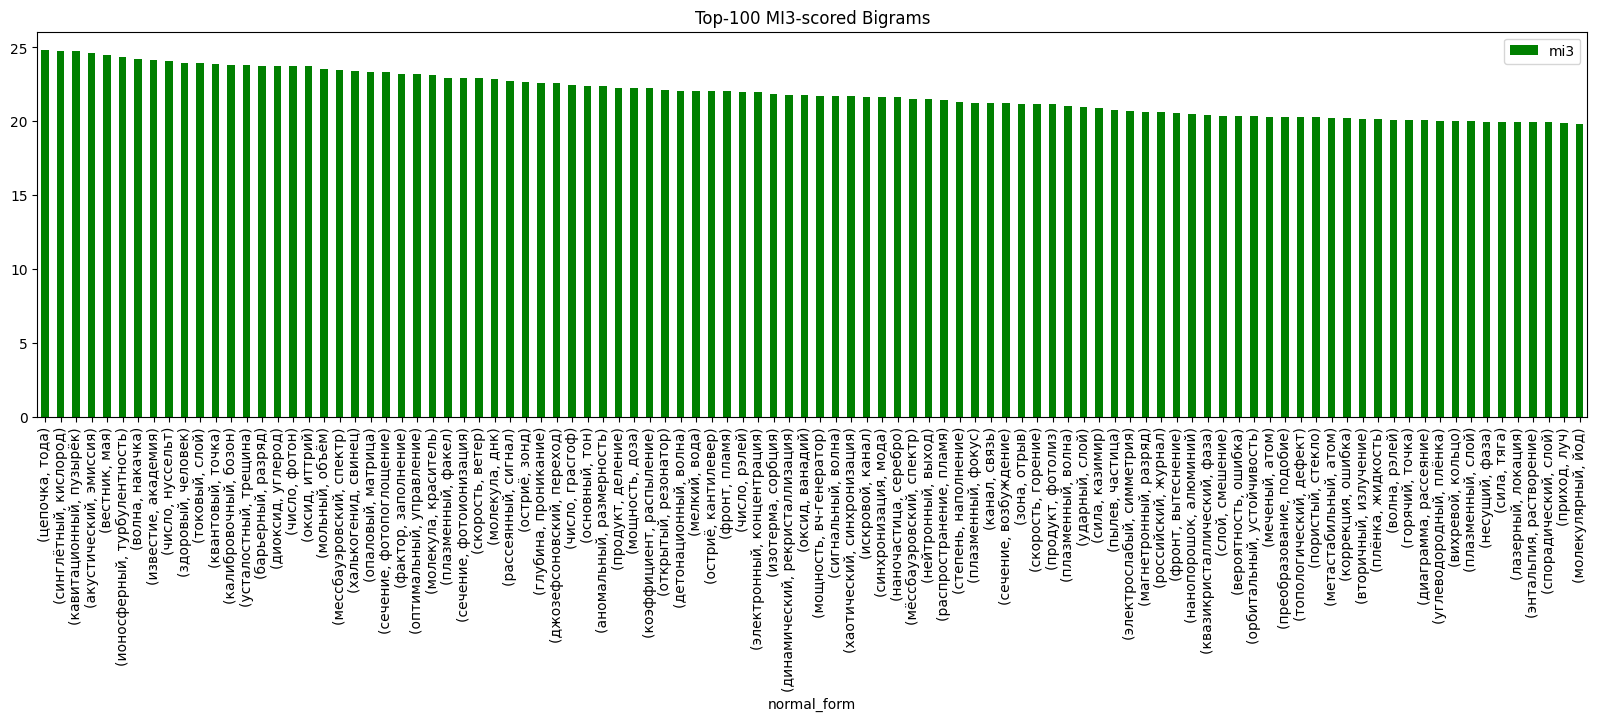

In [30]:
mi3_plot = visual_mi3.head(100).plot(
    x='normal_form', y='mi3', kind='bar', title='Top-100 MI3-scored Bigrams', figsize=(20, 5), color='green'
)

### 3. Context retrieval

Новые термины чаще всего встречаются в начале предложения (их описывают). Проверим, какие биграммы удовлетворяют этому условию.

Введем пороги, по которым будем отличать длинные предложения от средних и коротких:

In [31]:
SHORT_SENT_THRESHOLD = 0.35
MEDIUM_SENT_THRESHOLD = 0.5
LONG_SENT_THRESHOLD = 0.7

SHORT_SENT_MAX_LEN = 10
MEDIUM_SENT_MAX_LEN = 15

Не будем учитывать предложения без "сказуемого" (без семантического анализа их редко когда можно точно определить):

In [32]:
def has_predicate(lemmatizer, cache, tokens, predicates):
    """Checks if the sentence contains a predicate."""
    for token in tokens:
        token_pos = get_or_cache_token_parse(lemmatizer, token, cache).tag.POS
        if token_pos in predicates:
            return True

    return False

In [33]:
def is_definition(bigram, tokens):
    """Checks if the sentence has a structure <... bigram ... - ...>."""
    hyphens = ('-', '−', '–', '—')
    for x in hyphens:
        if x in tokens:
            split_idx = tokens.index(x)
            pre_define = tokens[:split_idx]

            if bigram[0] in pre_define and bigram[1] in pre_define:
                bigram_end_idx = tokens.index(bigram[1])

                if split_idx - bigram_end_idx <= 5:
                    return True

    return False

Извлечем предложения-контексты:

In [34]:
article_info = dict(rus_articles)

In [35]:
bigram_desc_mi3 = bigram_mi3_df.to_dict('records')
predicates = {'INFN', 'VERB', 'PRTS'}

bigram_contexts = {}
for bigram_info in tqdm(bigram_desc_mi3, desc='Extracting bigram contexts'):
    unigram_1 = bigram_info['unigram_1']
    unigram_2 = bigram_info['unigram_2']
    bigram_name = f'{unigram_1}_{unigram_2}'
    bigram_articles = eval(bigram_info['articles_id_list'])

    bigram_file_info = {}
    for article_id in bigram_articles:
        matching_sentences = []

        sentences = sent_tokenize(article_info[article_id], language='russian')
        total_sentences = len(sentences)
        for sentence_idx, sentence in enumerate(sentences):
            # sentence must start with a capital letter
            if not sentence[0].isupper():
                continue

            tokens = word_tokenize(sentence.lower(), language='russian')
        
            standardized_tokens = []
            for token in tokens:
                if match_unigram(token):
                    standardized_tokens.append(token)

            for i in range(len(standardized_tokens) - 1):
                token1, token2 = standardized_tokens[i], standardized_tokens[i + 1]
        
                token1_parse = get_or_cache_token_parse(lemmatizer, token1, pm2_cache)
                token2_parse = get_or_cache_token_parse(lemmatizer, token2, pm2_cache)

                # bigram must appear before the predicate
                if token1_parse.tag.POS in predicates or token2_parse.tag.POS in predicates:
                    break
        
                if token1_parse.normal_form in stop_words or token2_parse.normal_form in stop_words:
                    continue
        
                bigram_data = match_bigram(token1_parse, token2_parse)
                if bigram_data is not None:
                    bigram, bigram_pattern = bigram_data
        
                    if bigram in stop_bigrams:
                        continue

                    if bigram == (unigram_1, unigram_2):
                        sent_len = len(standardized_tokens)

                        # sentence must contain a predicate or meet a definition template
                        if (
                            not has_predicate(lemmatizer, pm2_cache, standardized_tokens, predicates)
                            and not is_definition((token1, token2), tokens)
                        ):
                            break
                        
                        # the closer bigram to the beginning of the sentence, the bigger its weight
                        bigram_weight = 1 - i / sent_len
                        
                        # saving only those contexts where bigram appeared in the beginning
                        if (
                            sent_len <= SHORT_SENT_MAX_LEN and bigram_weight >= SHORT_SENT_THRESHOLD
                            or sent_len > SHORT_SENT_MAX_LEN and sent_len <= MEDIUM_SENT_MAX_LEN and bigram_weight >= MEDIUM_SENT_THRESHOLD
                            or sent_len > MEDIUM_SENT_MAX_LEN and bigram_weight >= LONG_SENT_THRESHOLD
                        ):
                            matching_sentences.append((bigram_weight, sentence_idx + 1, sentence))

                        # bigram found -> stop searching
                        break

        # saving only articles with restriction-fitting contexts
        if matching_sentences:
            bigram_file_info[article_id] = [matching_sentences, total_sentences]

    # saving extracted bigram contexts
    bigram_contexts[bigram_name] = bigram_file_info

Extracting bigram contexts:   0%|          | 0/211 [00:00<?, ?it/s]

In [36]:
len(bigram_contexts)

211

In [37]:
bigram_contexts['акустический_ось'][11714128]

[[(1.0,
   218,
   'Акустическая ось расщепляется на две конического типа с индексом Пуанкаре a1/2, причем, в отличие от влияния внешнего электрического поля, в котором расщепление акустической оси происходит в плоскости (110), данное давление вызывает расщепление в плоскости (001).'),
  (0.9259259259259259,
   219,
   'Вследствие расщепления акустической оси при падении продольной волны в интервале между наведенными акустическими осями отражается медленная сдвиговая QSS-волна, т.е. в растворе конуса наведенных акустических осей происходит "обмен" сдвиговых упругих волн.')],
 254]

### 4. Relation Extraction

Существует, как минимум, 2 подхода к решению задачи извлечения/классификации отношений:
- основанный на правилах;
- нейросетевой.

___

Первый подход подразумевает написание правил-шаблонов, по которым определяется тип отношений в предложении. Он:
1. относительно простой с точки зрения реализации и требований к датасету;
2. затратный по времени разработчика системы правил;
3. очень плохо масштабируется;
4. выделяет отношения, основываясь только на знании лексики и синтаксиса;
5. обеспечивает высокий precision, но низкий recall (то, что нашлось, классифицируется достаточно точно, но далеко не все вообще находится).

___

Второй подход использует средства глубокого обучения для автоматического выделения отношений. Он:
1. достаточно тяжелый (часто используют модификации BERT-a) в реализации;
2. требует большой размеченной выборки (даже при использлвании предобученных моделей);
3. хорошо масштабируется (модель не использует ничего "ручного");
4. при выделении отношений учитывает и семантику контекста;
5. precision < 1-го подхода, recall > 1-го подхода (раз находим больше кандидатов, то и в среднем классифицируем их хуже).

___

Авторы рассмотренной статьи использовали 2-ой подход (R-BERT) для извлечения отношений из корпуса абстрактов статей по IT-тематике. Однако в нашем случае будем использовать 1-ый подход. Почему?
- Нет размеченной выборки. Без этого не обучить нормально ни один классификатор. У авторов статьи в распоряжении был RuSERRC датасет, в котором есть 80 размеченных абстрактов (что, честно говоря, очень мало для такой сложной задачи NLP), и то им пришлось идти на ухищрения: задействовали предобученный многоязычный BERT, обучили его на датасете англоязычных статей SciERC, и после использовали RuSERRC для валидации. Проблема в том, что абстракты в этих датасетах имеют IT-направленность, т.е. их нельзя использовать для обучения классификатора предложений физической тематики. Размечать самому - не вариант.
- Если действовать аналогично решениям авторов статьи, то разница в качестве между 1-ым и 2-ым подходами не очень значительна (F1-мера 0.23 -> 0.25). Пока что мне кажется, что пытаться здесь задействовать нейронки нецелесообразно (да и не подразумевалось от меня, наверное).

___

#### 4.1 Classification Stage

Зададим типы извлекаемых отношений:

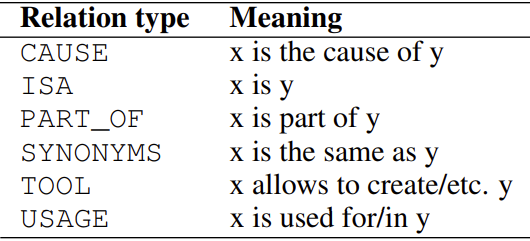

Все контексты, для которых не удалось определить тип отношений, будем помечать как NONE:

In [38]:
relation_types = ('CAUSE', 'DEFINITION', 'USAGE', 'PART_OF', 'SYNONYMS', 'TOOL', 'NONE')

In [46]:
def find_bigram_idx_in_sentence(bigram, sentence_parse):
    """Searches bigram's starting position in the sentence parse."""
    start_token = bigram[0]

    for i, parse in enumerate(sentence_parse):
        if parse.normal_form == start_token:
            return i

    return -1

Построим систему правил-шаблонов, по которым будет осуществляться классификация предложений:

In [47]:
def is_cause_pattern(bigram, bigram_idx, sentence_parse):
    """Checks if the bigram has a CAUSE type relation in the sentence."""
    return False

In [48]:
def is_definition_pattern(bigram, bigram_idx, sentence_parse):
    """Checks if the bigram has a DEFINITION type relation in the sentence."""
    return False

In [54]:
def is_usage_pattern(bigram, bigram_idx, sentence_parse):
    """Checks if the bigram has a USAGE type relation in the sentence."""
    for i, parse in enumerate(sentence_parse):
        if parse.normal_form == 'использование':
            for j in range(1, 6):
                complement = sentence_parse[min(i + j, len(sentence_parse) - 1)] 
                if complement.normal_form == bigram[0] and complement.tag.case == 'gent':
                    return True
    return False

In [50]:
def is_partof_pattern(bigram, bigram_idx, sentence_parse):
    """Checks if the bigram has a PART_OF type relation in the sentence."""
    return False

In [51]:
def is_synonyms_pattern(bigram, bigram_idx, sentence_parse):
    """Checks if the bigram has a SYNONYMS type relation in the sentence."""
    return False

In [52]:
def is_tool_pattern(bigram, bigram_idx, sentence_parse):
    """Checks if the bigram has a TOOL type relation in the sentence."""
    return False

In [56]:
def classify_relation(bigram, sentence_tokens, lemmatizer, cache):
    """Classifies bigram's relation type in the sentence."""
    # getting parses for all tokens in the sentence
    sentence_parse = [get_or_cache_token_parse(lemmatizer, token, cache) for token in sentence_tokens]
    bigram_idx = find_bigram_idx_in_sentence(bigram, sentence_parse)

    # any successful case
    if is_cause_pattern(bigram, bigram_idx, sentence_parse):
        return 'CAUSE'
    if is_definition_pattern(bigram, bigram_idx, sentence_parse):
        return 'DEFINITION'
    if is_usage_pattern(bigram, bigram_idx, sentence_parse):
        return 'USAGE'
    if is_partof_pattern(bigram, bigram_idx, sentence_parse):
        return 'PART_OF'
    if is_synonyms_pattern(bigram, bigram_idx, sentence_parse):
        return 'SYNONYMS'
    if is_tool_pattern(bigram, bigram_idx, sentence_parse):
        return 'TOOL'

    # failed case
    return 'NONE'

#### 4.2 Results Saving Stage

Будем сохранять информацию об отношениях в контекстах биграмм в директорию "context_relations":

In [55]:
contexts_directory = '../data/context_relations'

Результаты по каждой биграмме запишем в файл вида "unigram1_unigram2.txt":  

In [ ]:
for bigram in bigram_contexts:
    file_name = f'{contexts_directory}/{bigram}.txt'
    bigram_split = tuple(bigram.split('_'))

    with open(file_name, 'w') as f:
        pass

In [54]:
bigram_desc_mi3 = bigram_mi3_df.to_dict('records')
predicates = {'INFN', 'VERB', 'PRTS'}

for bigram_info in tqdm(bigram_desc_mi3, desc='Extracting bigram contexts'):
    unigram_1 = bigram_info['unigram_1']
    unigram_2 = bigram_info['unigram_2']
    bigram_articles = eval(bigram_info['articles_id_list'])

    file_name = f'{contexts_directory}/{unigram_1}_{unigram_2}.txt'
    with open(file_name, 'w') as f:
        for article_id in bigram_articles:
            matching_sentences = []

            sentences = sent_tokenize(article_info[article_id], language='russian')
            total_sentences = len(sentences)
            for sentence_idx, sentence in enumerate(sentences):
                # sentence must start with a capital letter
                if not sentence[0].isupper():
                    continue

                tokens = word_tokenize(sentence.lower(), language='russian')
            
                standardized_tokens = []
                for token in tokens:
                    if match_unigram(token):
                        standardized_tokens.append(token)

                for i in range(len(standardized_tokens) - 1):
                    token1, token2 = standardized_tokens[i], standardized_tokens[i + 1]
            
                    token1_parse = get_or_cache_token_parse(lemmatizer, token1, pm2_cache)
                    token2_parse = get_or_cache_token_parse(lemmatizer, token2, pm2_cache)

                    # bigram must appear before the predicate
                    if token1_parse.tag.POS in predicates or token2_parse.tag.POS in predicates:
                        break
            
                    if token1_parse.normal_form in stop_words or token2_parse.normal_form in stop_words:
                        continue
            
                    bigram_data = match_bigram(token1_parse, token2_parse)
                    if bigram_data is not None:
                        bigram, bigram_pattern = bigram_data
            
                        if bigram in stop_bigrams:
                            continue

                        if bigram == (unigram_1, unigram_2):
                            sent_len = len(standardized_tokens)

                            # sentence must contain a predicate or meet a definition template
                            if (
                                not has_predicate(lemmatizer, pm2_cache, standardized_tokens, predicates)
                                and not is_definition((token1, token2), tokens)
                            ):
                                break
                            
                            # the closer bigram to the beginning of the sentence, the bigger its weight
                            bigram_weight = 1 - i / sent_len
                            
                            # saving only those contexts where bigram appeared in the beginning
                            if (
                                sent_len <= SHORT_SENT_MAX_LEN and bigram_weight >= SHORT_SENT_THRESHOLD
                                or sent_len > SHORT_SENT_MAX_LEN and sent_len <= MEDIUM_SENT_MAX_LEN and bigram_weight >= MEDIUM_SENT_THRESHOLD
                                or sent_len > MEDIUM_SENT_MAX_LEN and bigram_weight >= LONG_SENT_THRESHOLD
                            ):
                                matching_sentences.append((bigram_weight, sentence_idx + 1, sentence))

                            # bigram found -> stop searching
                            break

            # writing only articles with restriction-fitting contexts
            if matching_sentences:
                f.write(f'Статья №{article_id}.\n')
                f.write('-' * 120)
                f.write('\n')

                for weight, idx, sentence in matching_sentences:
                    f.write(f'{idx}. {sentence}\n')

                f.write('*' * 120)
                f.write('\n')
                f.write(f'ВСЕГО: {total_sentences} предложений.\n')
                f.write('\n')

    # delete bigram file if empty
    if os.stat(file_name).st_size == 0:
        os.remove(file_name)

Extracting bigram contexts:   0%|          | 0/211 [00:00<?, ?it/s]

### 5. Conclusion

#### 5.1 Notes

- в корпусе среди статей было обнаружено **очень много "шумных" (~27% всей выборки!)**, а именно:
    1. англоязычные;
    2. французоязычные (не шутка, но их мало, и часто они представляют из себя фиктивные статьи - только заголовок, тела нет);
    3. русскоязычные, но не относящиеся никак к физике (видел на темы чистого мат.стата и даже стоматологии), их не удалял (а как их фильтровать?), но они влияния никакого не оказали на результирующую выборку.
- лемматизацию удалось **ускорить в 40 раз**, с 4 часов до 6 минут;
- **подходящих биграмм достаточно мало** - 235 на 11к статей, но даже среди них топ по метрике MI3 был малоинформативен -> поставил ограничение MI3 <= 25;
- саму метрику MI3 исправил, теперь размер корпуса считается с повторениями словоформ;
- теперь **биграммы представляю в виде "(нормальная_форма_1, нормальная форма_2)"** -> нет проблем с "длина волны" и "длина волн";
- поскольку биграмм-кандидатов мало, решил для ВСЕХ собрать контекстные предложения;
- Часто предложения выделяются неаккуратно, но делал это nltk, я тут ни при чем :)
- Все контексты сохранил в архив, на каждую биграмму есть свой файл с именем "<униграмма1>_<униграмма2>.txt". Содержимое каждого такого файла:
    1. id очередной статьи;
    2. список предложений-контекстов, отсортированный по *возрастанию относительной позиции биграммы* в предложениях - таким образом, сначала идут предложения, где биграмма встречалась в начале (или в середине, если предложение длинное). Сделал это, чтобы нам проще было анализировать эти самые контексты.
- **(NEW)** помимо предложенных ограничений *(биграмма до глагола, предложение начинается с заглавной буквы)*, добавил еще следующие:
    - **разные пороги позиций биграммы в зависимости от длины предложения**. В коротких предложениях порог щадящий, биграмма должна находиться в первых 65% предложения; в длинных отрубается жестко - в первых 30%. Просто отсекать по позиции относительно глагола недостаточно, т.к.
        1. глагол сам может быть в конце предложения, а нам хотелось бы видеть биграмму около начала;
        2. не во всех предложениях сказуемое выражено глаголом (и даже кратким причастием).
    - **рассмотрение позиции относительно сказуемого, а не просто глагола**. Очень часто глагол заменялся в предложениях кратким причастием, поэтому решил эти моменты тоже учесть. Честно говоря, без семантического анализа точно извлечь сказуемое невозможно. Поэтому пришлось схитрить: я заметил, что в выборке в качестве сказуемого в большинстве случаев выступают глаголы, краткие причастия, или существительные (причем последние встречаются в шаблоне "термин - определение термина"). Первые 2 случая легко отфильтровать, а для последнего написал псевдо-шаблон;
    - **удаление предложений, не содержащих сказуемое**. В выборке достаточно много описаний графиков, схем, таблиц, и т.д. Эти предложения выглядят наподобие "Схема процесса i". Т.е. ни глаголов, ни даже причастий. Такие предложения нас, скорее всего, мало интересуют.
- **(NEW)** теперь **предложения выводятся со своим реальным номером в статье** (и упорядочены они тоже по нему). Чтобы легче определять, где примерно в статье есть скопление контекстов, для каждой статьи в конце вывожу статистику, сколько всего в ней предложений (хотел изначально вообще выводить топ-k кластеров, но передумал :)).
- **(NEW)** все-таки **не до конца удалось вычистить мусор из выдачи**. Так, например, токенизатор изначально не может правильно выделить предложение из-за находящихся рядом метаданных (типа заголовка, внутри которого находится биграмма, он к заголовку подтянет еще и следующее за ним предложение). Т.е. часть предложений с самого начала малоинформативна, но выживает отсеивание из-за своего формата. Что делать с этим не очень понятно, т.к. нет какого-то единого паттерна, по которым эти метаданные можно было бы обрезать.

#### 5.2 Improvements

- **TO-DO:**
    1. ;
    2. ;
    3. .